# 2-step PSB metallicity evoltuion, using lognorm scatter before burst and delta after
Following experiments in `lognorm_metallicity_scatter.ipynb`, both just lognorm scatter and lognorm scatter on top of the 2-step PSB metallicity enrichment models do not seem to work. Observations from `Yirui_test_cube/simulation_info/read_star_particles_info.ipynb` seems to suggest that the scatter in metallicity becomes much more narrow during and after burst, at least in Yirui's simulated galaxy. So in this notebook, we test swapping out lognorm for delta in the post-burst scatter distribution.

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.optimize import curve_fit

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


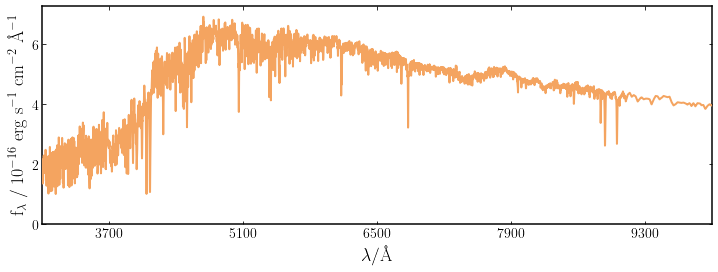

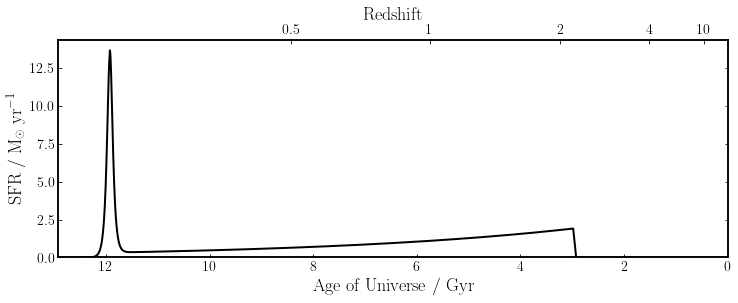

(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>)

In [2]:
# creating toy bagpipes models to extract inputs into chemical_enrichment_history.__init__ for later testing
# purposes
psb = {}
psb['massformed'] = 10
psb['metallicity'] = 1.0
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

obs_wavs = np.arange(3000., 10000., 1.)
baseline_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
baseline_model.plot()
baseline_model.sfh.plot()

In [3]:
# adding lognorm to chemical_enrichment_history.py
"""
structure = within psb_wild2020
where dictionary metallicity has structure:
['metallicity_type'] = 'constant' or 'psb_two_step'
if 'constant':
    ['metallicity'] = xx
if 'psb_two_step':
    ['metallicity_old'] = xx
    ['metallicity_burst'] = xx
['metallicity_scatter'] = 'delta' or 'exp' or 'lognorm'
"""

pipes.config.zmet_sampling = np.arange(0., 10., 0.01) + 0.005
import bagpipes.config as config

def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            if 'metallicity_type' not in model_comp[comp].keys():
                self.grid_comp[comp] = self.delta(model_comp[comp],
                                                  sfh_weights[comp])
            else:
                self.grid_comp[comp] = getattr(self, model_comp[comp]['metallicity_type']
                                              )(model_comp[comp],sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid

def delta(self, comp, sfh, zmet=None, nested=False):
    """ Delta function metallicity history. """

    #if zmet is None:
    #    zmet = comp["metallicity"]

    weights = np.zeros(self.zmet_vals.shape[0])

    high_ind = self.zmet_vals[self.zmet_vals < zmet].shape[0]

    if high_ind == self.zmet_vals.shape[0]:
        weights[-1] = 1.

    elif high_ind == 0:
        weights[0] = 1.

    else:
        low_ind = high_ind - 1
        width = (self.zmet_vals[high_ind] - self.zmet_vals[low_ind])
        weights[high_ind] = (zmet - self.zmet_vals[low_ind])/width
        weights[high_ind-1] = 1 - weights[high_ind]

    return weights
    '''
    if nested:
        return weights
    else:
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)
    '''
    
def exp(self, comp, sfh, zmet=None, nested=False):
    """ P(Z) = exp(-z/z_mean). Currently no age dependency! """

    #if zmet is None:
    #    tau_zmet = comp["metallicity"]
    #else:
    tau_zmet = zmet

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = (1./mean_zmet)*np.exp(-vals_hr/tau_zmet)

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])

    return weights
    '''
    if nested:
        return weights
    else:
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)
    '''
    
def lognorm(self, comp, sfh, zmet=None, nested=False):
    """
    log normal metallicity distribution scatter. 
    Functional form: P(x) = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    where mu = ln(metallicity mean), sigma = some concentration measurement
    """
    
    #if zmet is None:
    #    mean_zmet = np.log(comp["metallicity"])
    #else:
    log_mean_zmet = np.log(zmet)
    sigma = 0.45

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = 1/(vals_hr*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(vals_hr)-log_mean_zmet)**2/(2*sigma**2))

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])

    return weights
    '''
    if nested:
        return weights
    else:
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)
    '''
    
def constant(self, comp, sfh):
    """ constant metallicity without any variation in time """
    
    zmet = comp["metallicity"]
    if "metallicity_scatter" not in comp.keys():
        comp["metallicity_scatter"] = "delta"
    
    weights = getattr(self, comp['metallicity_scatter']
                     )(comp, sfh, zmet=SSP_zmet, nested=True)
    return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)

def psb_two_step(self, comp, sfh):
    """ 2-step metallicities (time-varying!) for psb SFH shape, shift at burstage """
    
    zmet_old = comp["metallicity_old"]
    zmet_burst = comp["metallicity_burst"]
    burstage = comp["burstage"]*10**9
    if "metallicity_scatter" not in comp.keys():
        comp["metallicity_scatter"] = 'delta'
    
    # get SSP ages
    SSP_ages = config.age_sampling
    SSP_age_bins = config.age_bins
    
    # loop through all SSP ages
    zmet_comp = np.zeros((self.zmet_vals.shape[0], sfh.shape[0]))
    for i,agei in enumerate(SSP_ages):
        # detect if the SSP age's higher boundary > tburst and lower boundary < tburst
        if SSP_age_bins[i+1]>burstage and SSP_age_bins[i]<burstage:
            # interp between to get metallicity at this SSP
            width = SSP_age_bins[i+1] - SSP_age_bins[i]
            old_weight = (SSP_age_bins[i+1] - burstage)/width
            burst_weight = (burstage - SSP_age_bins[i])/width
            SSP_zmet = old_weight*zmet_old + burst_weight*zmet_burst
            # weights from metallicity scatter
            if comp['metallicity_scatter'] == 'concentrate':
                zmet_comp[:,i] = getattr(self, 'delta'
                                        )(comp, sfh, zmet=SSP_zmet, nested=True)
            else:
                zmet_comp[:,i] = getattr(self, comp['metallicity_scatter']
                                        )(comp, sfh, zmet=SSP_zmet, nested=True)
        
        # if before tburst
        elif SSP_age_bins[i]>burstage:
            # weights from metallicity scatter
            if comp['metallicity_scatter'] == 'concentrate':
                zmet_comp[:,i] = getattr(self, 'lognorm'
                                        )(comp, sfh, zmet=zmet_old, nested=True)
            else:
                zmet_comp[:,i] = getattr(self, comp['metallicity_scatter']
                                        )(comp, sfh, zmet=zmet_old, nested=True)
            
        # if after tburst
        elif SSP_age_bins[i+1]<burstage:
            # weights from metallicity scatter
            if comp['metallicity_scatter'] == 'concentrate':
                zmet_comp[:,i] = getattr(self, 'delta'
                                        )(comp, sfh, zmet=zmet_burst, nested=True)
            else:
                zmet_comp[:,i] = getattr(self, comp['metallicity_scatter']
                                        )(comp, sfh, zmet=zmet_burst, nested=True)
            
        else:
            print('help')
    
    #print(zmet_comp)
    return zmet_comp*np.expand_dims(sfh, axis=0)

pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.delta = delta
pipes.models.chemical_enrichment_history.exp = exp
pipes.models.chemical_enrichment_history.lognorm = lognorm
pipes.models.chemical_enrichment_history.constant = constant
pipes.models.chemical_enrichment_history.psb_two_step = psb_two_step

In [4]:
# new toy model: two step with all lognorm scatter
psb = {}
psb['massformed'] = 10
psb['metallicity_type'] = 'psb_two_step'
psb['metallicity_old'] = 1.0
psb['metallicity_burst'] = 2.0
psb['metallicity_scatter'] = 'lognorm'
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components2 = {}
model_components2['psb_wild2020'] = psb
model_components2['redshift'] = 0.04

twostep_lognorm_model = pipes.model_galaxy(model_components2, spec_wavs=obs_wavs)

In [5]:
# new toy model: two step with concentrate scatter, meaning before and at peak of burst: lognorm scatter, 
# after burst: delta
psb = {}
psb['massformed'] = 10
psb['metallicity_type'] = 'psb_two_step'
psb['metallicity_old'] = 1.0
psb['metallicity_burst'] = 2.0
psb['metallicity_scatter'] = 'concentrate'
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components3 = {}
model_components3['psb_wild2020'] = psb
model_components3['redshift'] = 0.04

twostep_conc_model = pipes.model_galaxy(model_components3, spec_wavs=obs_wavs)

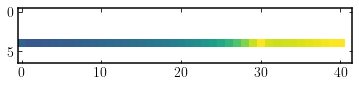

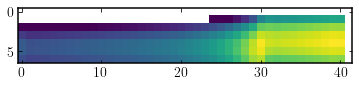

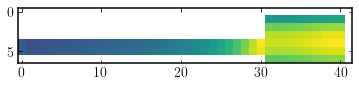

In [6]:
from matplotlib.colors import LogNorm
plt.imshow(baseline_model.sfh.ceh.grid, norm=LogNorm(vmin=1e-6, 
                                                     vmax=np.max(baseline_model.sfh.ceh.grid)))
plt.show()
plt.imshow(twostep_lognorm_model.sfh.ceh.grid, norm=LogNorm(vmin=1e-6, 
                                                            vmax=np.max(twostep_lognorm_model.sfh.ceh.grid)))
plt.show()
plt.imshow(twostep_conc_model.sfh.ceh.grid, norm=LogNorm(vmin=1e-6, 
                                                         vmax=np.max(twostep_conc_model.sfh.ceh.grid)))
plt.show()

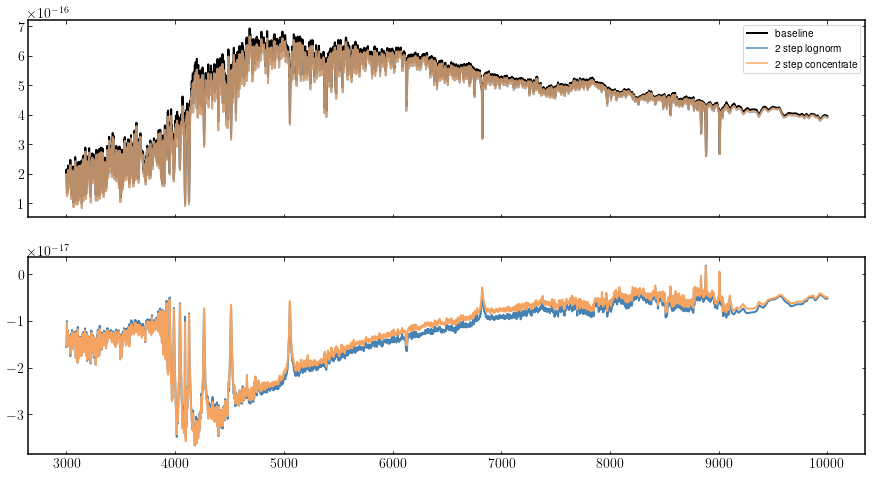

In [7]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, baseline_model.spectrum[:,1], label='baseline', color='black')
ax[0].plot(obs_wavs, twostep_lognorm_model.spectrum[:,1], label='2 step lognorm', color='steelblue', alpha=0.7)
ax[0].plot(obs_wavs, twostep_conc_model.spectrum[:,1], label='2 step concentrate', color='sandybrown', alpha=0.7)
ax[0].legend()
ax[1].plot(obs_wavs, twostep_lognorm_model.spectrum[:,1] - baseline_model.spectrum[:,1], color='steelblue')
ax[1].plot(obs_wavs, twostep_conc_model.spectrum[:,1] - baseline_model.spectrum[:,1], color='sandybrown')

plt.show()

## Applying "concentrate" scatter scheme on Yirui's galaxy

In [8]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname='../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                          ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

def get_fit_instructions(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2['metallicity_type'] = 'psb_two_step'
    psb2['metallicity_old'] = (0.01, 3.5)
    psb2['metallicity_old_prior'] = 'log_10'
    psb2['metallicity_burst'] = (0.01, 3.5)
    psb2['metallicity_burst_prior'] = 'log_10'
    psb2['metallicity_scatter'] = 'concentrate'
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

In [9]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_type': 'psb_two_step', 'metallicity_old': (0.01, 3.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 3.5), 'metallicity_burst_prior': 'log_10', 'metallicity_scatter': 'concentrate', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [10]:
pipes.config.Rspec = 4340
runID = "two_step_concentrate_metallicity_yirui_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 10646.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               6.176      7.886     10.296
psb_wild2020:alpha           168.269    189.177    204.344
psb_wild2020:burstage          0.481      0.506      0.553
psb_wild2020:fburst            0.164      0.178      0.198
psb_wild2020:massformed       10.673     10.717     10.771
psb_wild2020:metallicity_burst      2.396      2.734      2.971
psb_wild2020:metallicity_old      1.308      1.538      1.790
psb_wild2020:tau               3.179      6.058      8.844
redshift                       0.040      0.040      0.040




In [11]:
def plot_spec(fit, ID, runID):

    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID, model_f_burst=None, model_burstage=None):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')
    print(np.log10(post_m_total), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    if model_f_burst is None and model_burstage is None:
        model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
            model_lookbacktime.copy(), model_sfh, age_at_z)
    else:
        model_t_burst = age_at_z - model_burstage
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb_wild2020:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb_wild2020:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax

In [13]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

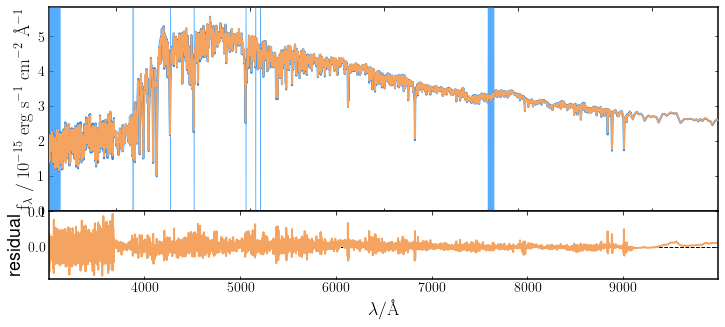

only recovered 0.4228102046797988 of total mass formed.
10.652547640761437 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.374067971253364
posterior f_burst and t_burst: [0.16346231 0.17690623 0.19891899] [12.36300845 12.41694029 12.44586001]


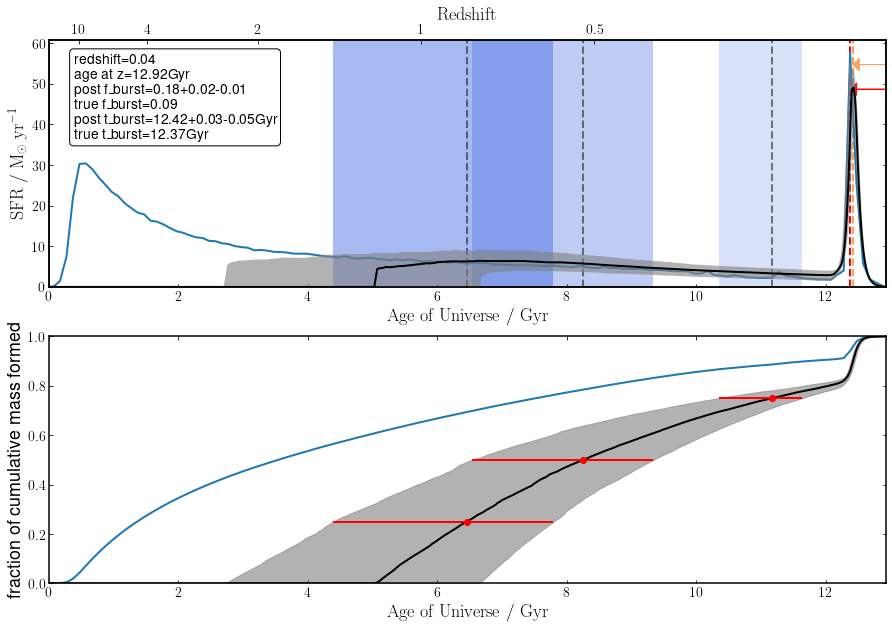

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [14]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, model_ages, model_sfh, ID, runID)

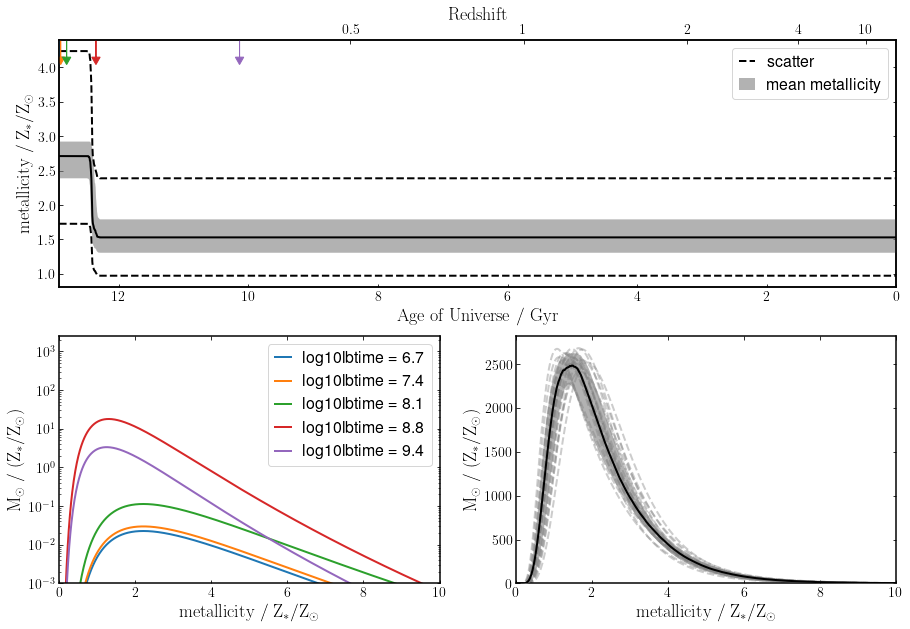

In [15]:
def lognorm_plot(mean_zmet, x=np.arange(0., 10., 0.01) + 0.005):
    log_mean_zmet = np.log(mean_zmet)
    sigma = 0.45
    if 'array' in str(type(mean_zmet)):
        log_mean_zmet = np.expand_dims(log_mean_zmet, axis=1)
    pdf = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-log_mean_zmet)**2/(2*sigma**2))
    return pdf

def get_ceh(self):
    self.samples["ceh"] = np.zeros((self.n_samples, len(self.sfh.ages)))
    for i in range(self.n_samples):
        for j in range(len(self.sfh.ages)):
            if self.sfh.ages[j] > self.samples['psb_wild2020:burstage'][i]*10**9:
                self.samples["ceh"][i,j] = self.samples['psb_wild2020:metallicity_old'][i]
            else:
                self.samples["ceh"][i,j] = self.samples['psb_wild2020:metallicity_burst'][i]

pipes.fitting.posterior.get_ceh = get_ceh
                
def plot_ceh_posterior(fit, z_axis=True, zvals=[0, 0.5, 1, 2, 4, 10]):
    import bagpipes.utils as utils
    from bagpipes.plotting.general import add_z_axis,tex_on
    fit.posterior.get_ceh()
    
    fig = plt.figure(figsize=[15,10])
    gs = matplotlib.gridspec.GridSpec(2,2)
    mainax = plt.subplot(gs[0,:])
    leftax = plt.subplot(gs[1,0])
    rightax = plt.subplot(gs[1,1])
    
    # Calculate median redshift and median age of Universe
    if "redshift" in fit.fitted_model.params:
        redshift = np.median(fit.posterior.samples["redshift"])

    else:
        redshift = fit.fitted_model.model_components["redshift"]

    age_of_universe = np.interp(redshift, utils.z_array, utils.age_at_z)

    # Calculate median and confidence interval for mean metallicity posterior
    mean_zmet_percentiles = np.percentile(fit.posterior.samples['ceh'], (16,50,84), axis=0).T

    # Plot the CEH
    x = age_of_universe - fit.posterior.sfh.ages*10**-9

    mainax.plot(x, mean_zmet_percentiles[:, 1], color='black', zorder=4+1)
    mainax.fill_between(x, mean_zmet_percentiles[:, 0], mean_zmet_percentiles[:, 2], 
                        color='gray',
                        alpha=0.6, zorder=4, lw=0, label='mean metallicity')
    
    # dotted lines showing 16th and 84th percentile of scatter distribution across time if assuming
    # mean metallicity = posterior median
    zmet_sampling = np.arange(0., 10., 0.01) + 0.005
    scatter_percentiles = np.zeros([len(x), 3])
    for i,median_zmet in enumerate(mean_zmet_percentiles[:,1]):
        pdf = lognorm_plot(median_zmet, x=zmet_sampling)
        scatter_percentile = np.interp([0.16,0.50,0.84], np.cumsum(pdf)*0.01, zmet_sampling)
        scatter_percentiles[i] = scatter_percentile
    mainax.plot(x, scatter_percentiles[:, 0], color='black', ls='--', zorder=4+1, label='scatter')
    mainax.plot(x, scatter_percentiles[:, 2], color='black', ls='--', zorder=4+1)
    
    #ax.set_ylim(0., np.max([ax.get_ylim()[1], 1.1*np.max(post[:, 2])]))
    mainax.set_xlim(age_of_universe, 0)

    # Add redshift axis along the top
    if z_axis:
        ax2 = add_z_axis(mainax, zvals=zvals)

    # Set axis labels
    if tex_on:
        mainax.set_ylabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
        mainax.set_xlabel("$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$")

    else:
        mainax.set_ylabel("metallicity / Z*/Z_sol")
        mainax.set_xlabel("Age of Universe / Gyr")
    mainax.legend()
    
    # bottom left plot: scatter cross sections
    n = 5
    ind = np.round(np.linspace(0, len(fit.posterior.sfh.ages)-1, n+2)).astype(int)[1:-1]
    main_ylims = mainax.get_ylim()
    for i in ind:
        this_mean_zmet = mean_zmet_percentiles[:,1][i]
        pdf = lognorm_plot(this_mean_zmet, x=zmet_sampling)
        # multiply by SFR at that age bin
        stellar_mass_dist = pdf * fit.posterior.sfh.sfh[i]
        p0 = leftax.plot(zmet_sampling, stellar_mass_dist, 
                         label='log10lbtime = '+str(np.round(np.log10(fit.posterior.sfh.ages[i]),1)))
        # add arrow to main plot to show when the cross sections are
        mainax.arrow(x[i], main_ylims[1], 0.0, -0.1*np.diff(main_ylims)[0],
                     color=p0[0].get_color(),head_width=0.01*np.diff(mainax.get_xlim())[0], 
                     head_length=0.3*0.1*np.diff(main_ylims)[0],length_includes_head=True, zorder=4+2)
    
    mainax.set_ylim(main_ylims)
    leftax.set_xlabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
    leftax.set_ylabel("$\\mathrm{M_\\odot\\ /\\ (Z_* / Z_{\\odot})}$")
    leftax.set_xlim(0,10)
    leftax.legend()
    leftax.set_yscale('log')
    leftax.set_ylim(bottom=10**-3)
    
    # bottom right plot: total scatter distribution
    all_samp_scatters = np.zeros([fit.posterior.n_samples, len(zmet_sampling)])
    for i in range(fit.posterior.n_samples):
        samp_mean_zmet = fit.posterior.samples['ceh'][i]
        samp_pdf = lognorm_plot(samp_mean_zmet)
        samp_stellar_mass_dist = np.expand_dims(fit.posterior.samples['sfh'][i], axis=1)*samp_pdf
        samp_summed_stellar_mass_dist = np.sum(samp_stellar_mass_dist, axis=0)
        all_samp_scatters[i] = samp_summed_stellar_mass_dist
    int_scatter_percentile = np.percentile(all_samp_scatters, (16,50,84), axis=0).T
    rightax.plot(zmet_sampling, int_scatter_percentile[:,1], color='black', zorder=4+1)
    rightax.fill_between(zmet_sampling, int_scatter_percentile[:,0], int_scatter_percentile[:,2],
                        color='gray', alpha=0.6, zorder=4, lw=0)
    rand_inds = np.random.randint(fit.posterior.n_samples, size=20)
    for randi in rand_inds:
        rightax.plot(zmet_sampling, all_samp_scatters[randi], color='gray', alpha=0.4, ls='--')
    
    rightax.set_xlabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
    rightax.set_ylabel("$\\mathrm{M_\\odot\\ /\\ (Z_* / Z_{\\odot})}$")
    rightax.set_xlim(0,10)
    rightax.set_ylim(bottom=0)
    plt.show()
    
plot_ceh_posterior(fit)